In [33]:
import json
import pandas as pd
from collections import defaultdict
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
import networkx as nx
from numpy.random import rand, RandomState
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import string
from nltk.tokenize import word_tokenize
import matplotlib
from mpl_toolkits.basemap import Basemap
import geopy
from sklearn.metrics.pairwise import linear_kernel
from geopy.geocoders import Nominatim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def json_to_dict(filename):
    '''
    INPUT: name of json file
    OUTPUT: dictionary with city keys and description values
    take json file and return dictionary
    '''
    di = {}
    english = []
    with open('wordlist.txt') as f:
        for line in f:
            english.append(line.strip('\r\n'))
            english.append(' ')
    english = set(english)

    with open(filename) as data_file:
        data = json.load(data_file)
        for item in data:
            for key in item.keys():
                # remove punctuation, make everything lower case
                txt = ''.join(ch.lower() for ch in item[key] if ch not in set(string.punctuation))
                # remove numbers
                txt = ''.join(c for c in txt if c.isdigit() is False)
                # remove the city name from its own description
                keyparts = key.split(',')
                txt = ' '.join(c for c in txt.split() if c != keyparts[0].lower() and c != keyparts[-1].lower())
                # remove non-english words
                txt = ' '.join(c for c in txt.split() if c in english)
                # populate dictionary
                di[key.strip().strip('\n').encode('ascii', 'ignore')] = txt
    return di

In [3]:
def combine_dictionaries(dict1, dict2, keys_file):
    '''
    INPUT: dictionaries and keys
    OUTPUT: dictionary with combined data and final key names
    take two dictionaries and combine into one
    '''
    combined_dict = {}
    with open(keys_file) as f:
        for line in f:
            d1_key = line.split('|')[0]
            d2_key = line.split('|')[1]
            final_key = line.split('|')[2].strip('\n')

            if d2_key == 'noname':
                combined_dict[final_key] = dict1.get(d1_key)
            elif d1_key == 'noname':
                combined_dict[final_key] = dict2.get(d2_key)
            else:
                combined_dict[final_key] = dict1.get(d1_key) + dict2.get(d2_key)
    return combined_dict

In [4]:
def remove_stopwords(corpus, words_to_add=[]):
    '''
    INPUT: tokenized document corpus, list of words to remove
    OUTPUT: document corpus with stop words removed
    take a list of words to add to stoplist and remove from corpus
    '''
    '''Use the English language stopwords provided by nltk'''
    stops = stopwords.words('english')
    
    '''Add user-requested stopwords'''
    stops.extend(words_to_add)
    
    '''Remove stop words from corpus and return'''
    #tokenized = [word_tokenize(content.lower()) for content in corpus]
    stops = set(stops)
    docs = [[word for word in words if word not in stops]
        for words in corpus]
    
    return docs

In [5]:
def plot_word_frequencies(tokenized_corpus, title):
    '''
    INPUT: tokenized corpus, plot title
    OUTPUT: vocabulary list, word ids, word counts
    take a tokenized corpus, calculate the frequency of each word, and plot
    '''
    '''Build a vocabulary of every unique word in the corpus'''
    vocab_set = set()
    [[vocab_set.add(token) for token in tokens] for tokens in tokenized_corpus]
    vocab = list(vocab_set)
    
    '''Make a dictionary relating word to id number'''
    vocab_dict = {word: i for i, word in enumerate(vocab)}
    
    '''Build word count matrix'''
    word_ids = np.zeros(len(vocab))
    word_counts = np.zeros((len(tokenized_corpus), len(vocab)))
    for doc_id, words in enumerate(tokenized_corpus):
        for word in words:
            word_id = vocab_dict[word]
            word_ids[word_id] = word_id
            word_counts[doc_id][word_id] += 1
    
    '''Count the total number of times each word occurs'''
    values = np.sum(word_counts, axis=0)
    
    '''Plot the results'''
    plt.bar(range(0,len(values)), sorted(values)[::-1], color='green', alpha=0.4)

    plt.xlabel('Word Index')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Chart - {}'.format(title))
    return np.array(values), vocab, word_ids

In [6]:
def build_synonym_list(word_list):
    '''
    INPUT: list of words
    OUTPUT: list containing words and all of their synonyms
    take a list of words and return a list containin all synonyms of those words
    '''
    all_synonyms = []
    for word in word_list:
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
        synlist.append(word.lower())
        all_synonyms.extend([wordnet.lemmatize(w) for w in synlist])
    return all_synonyms
    


In [7]:
def limit_speech_part(corpus, pts_of_speech = ['ADJ', 'NOUN', 'ADV', 'VERB']):
    '''
    INPUT: tokenized corpus, list of parts of speech to keep
    OUTPUT: list of words to remove
    take a tokenized corpus and return a list of words to remove from that are not in the part of speech list
    '''
    remove_words = []
    for words in corpus:
        for word in words:
            check = 0
            for ps in pts_of_speech:
                check += len(wn.synsets(word, pos=getattr(wn, ps)))
            if check == 0:
                remove_words.append(word)
    return remove_words

In [8]:
def get_personality_words():
    with open('personalitywords.txt') as f:
        personality_words = []
        for line in f:
            for word in line.split():
                synonyms = wn.synsets(word.lower())
                synlist = [word.lower()]
                for s in synonyms:
                    synlist = [l.name() for l in s.lemmas()]
                    personality_words.extend([wordnet.lemmatize(w) for w in synlist if len(wn.synsets(w, pos=wn.ADJ))>0])
    return set(personality_words)

In [9]:
def get_features_freq(city_list, cities, stop_wds, doc_bodies):
    vectorizer = CountVectorizer(stop_words=stop_wds)
    X = vectorizer.fit_transform(doc_bodies)
    features = vectorizer.get_feature_names()
    
    x_dense = X.todense() # convert feature matrix to dense
    for city in city_list:
        ind = np.where(cities==city)[0][0]
        city_words = np.array(x_dense[ind])[0]
        top_indices = np.array(np.argsort(city_words)[::-1][:8])
        print '{}: {}'.format(city, ', '.join(np.array(features)[top_indices]))

In [10]:
def get_features_tfidf(city_list, cities, stop_wds, doc_bodies):
    vectorizer = TfidfVectorizer(stop_words=stop_wds)
    X = vectorizer.fit_transform(doc_bodies)
    features = vectorizer.get_feature_names()
    
    x_dense = X.todense() # convert feature matrix to dense
    for city in city_list:
        ind = np.where(cities==city)[0][0]
        city_words = np.array(x_dense[ind])[0]
        top_indices = np.array(np.argsort(city_words)[::-1][:8])
        print '{}: {}'.format(city, ', '.join(np.array(features)[top_indices]))

### Initial data formatting:
Convert to dictionary, combine dictionaries, remove cities without text, convert to data frame

In [62]:
rs_dict = json_to_dict('../scraping/ricksteves_articles_blogs_R01.json')
ta_dict = json_to_dict('../scraping/europe_city_reviews2.json')

empty_count = 0
for k in ta_dict:
    if len(ta_dict[k]) < 100:
        empty_count += 1
print empty_count

key_list = set(rs_dict.keys() + ta_dict.keys())
europe_dict = dict()
for key in key_list:
    europe_dict[key] = str(rs_dict.get(key)) + str(ta_dict.get(key))
    
# remove cities which contain little or no text
europe_dict = {key: value for key, value in europe_dict.items() if len(value) > 200}
for k in europe_dict:
    if len(europe_dict[k]) < 100:
        print '\n', k
        print europe_dict[k]

# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(europe_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
# doc_bodies = cities_df['description']
doc_bodies = cities_df['description'].values
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]
cities = cities_df.index.values

wordnet = WordNetLemmatizer()
docs_wordnet = [' '.join([wordnet.lemmatize(word) for word in words.split()]) for words in doc_bodies]
tokenized_corpus_wn = [word_tokenize(content.lower()) for content in docs_wordnet]

65


### nltk stop words removed

In [12]:
tokenized_corpus_0 = remove_stopwords(tokenized_corpus)
print 'Most Common Words:'
get_features_freq(['Venice, Italy'], cities, stopwords.words('english'), doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stopwords.words('english'), doc_bodies)

Most Common Words:
Venice, Italy: one, see, tour, worth, great, church, place, beautiful

Tfidf Most Important Words:
Venice, Italy: canal, venetian, gondola, tour, see, one, worth, church


### Non-personality words removed

In [13]:
personalities = get_personality_words()
non_personalities = []
for words in tokenized_corpus_0:
    for word in words:
        syns = []
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
            syns.extend(synlist)
        if len(set.intersection(set(syns), personalities)) == 0:
            non_personalities.append(word)
            
stop_wds = set(stopwords.words('english') + non_personalities)
tokenized_corpus_1 = remove_stopwords(tokenized_corpus_0, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

11425 stopwords removed

Most Common Words:
Venice, Italy: one, see, tour, great, place, take, around, go

Tfidf Most Important Words:
Venice, Italy: tour, see, one, great, place, take, grand, around


### nltk stop words and nouns removed

In [14]:
nouns = limit_speech_part(tokenized_corpus_1, pts_of_speech = ['ADJ', 'ADJ_SAT', 'ADV', 'VERB'])
stop_wds = set(stopwords.words('english') + non_personalities + nouns)
tokenized_corpus_2 = remove_stopwords(tokenized_corpus_1, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

11661 stopwords removed

Most Common Words:
Venice, Italy: one, see, tour, great, place, take, around, go

Tfidf Most Important Words:
Venice, Italy: tour, see, one, great, place, take, grand, around


### nltk stop words, nouns and verbs removed

In [15]:
verbs = limit_speech_part(tokenized_corpus_2, pts_of_speech = ['ADJ', 'ADJ_SAT', 'ADV'])
stop_wds = set(stopwords.words('english') + non_personalities + nouns + verbs)
tokenized_corpus_3 = remove_stopwords(tokenized_corpus_2, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

12640 stopwords removed

Most Common Words:
Venice, Italy: one, great, around, go, like, well, little, grand

Tfidf Most Important Words:
Venice, Italy: one, great, grand, around, square, go, well, like


### nltk stop words, nouns, verbs and adverbs removed

In [16]:
adverbs = limit_speech_part(tokenized_corpus_3, pts_of_speech = ['ADJ', 'ADJ_SAT'])
stop_wds = set(stopwords.words('english') + non_personalities + nouns + verbs + adverbs)
tokenized_corpus_4 = remove_stopwords(tokenized_corpus_3, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

12728 stopwords removed

Most Common Words:
Venice, Italy: one, great, go, well, like, grand, little, good

Tfidf Most Important Words:
Venice, Italy: one, great, grand, square, go, well, like, little


### nltk stop words, nouns, verbs, adverbs, and common words removed

Word in corpus: 2102
Maximum word frequency: 17441
['even', 'free', 'top', 'best', 'lovely', 'easy', 'still', 'amazing', 'square', 'first', 'one', 'little', 'different', 'small', 'good', 'wonderful', 'like', 'back', 'nice', 'go', 'great', 'main', 'well', 'made']
['ex', 'x', 'go']
12754 stopwords removed

Most Common Words:
Venice, Italy: grand, last, going, found, busy, spent, open, quiet

Tfidf Most Important Words:
Venice, Italy: grand, going, quiet, busy, last, found, spent, unique


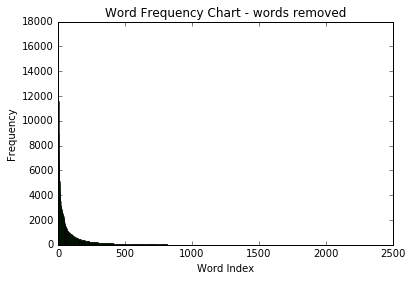

In [17]:
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus_4, 'words removed')
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))
vocab_dict = {i: word for i, word in enumerate(vocab)}
# remove any words that are very common
commonwords = word_ids[values > 3000]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

two_letter = [word for word in vocab if len(word) < 3]
print two_letter

stop_wds = set(stopwords.words('english') + non_personalities + nouns + verbs + adverbs + common_removelist + two_letter)
tokenized_corpus_5 = remove_stopwords(tokenized_corpus_4, stop_wds)
print '{} stopwords removed'.format(len(stop_wds))
print '\nMost Common Words:'
get_features_freq(['Venice, Italy'], cities, stop_wds, doc_bodies)
print '\nTfidf Most Important Words:'
get_features_tfidf(['Venice, Italy'], cities, stop_wds, doc_bodies)

In [18]:
commonwords = word_ids[values > 1500]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

['even', 'new', 'fantastic', 'excellent', 'free', 'top', 'modern', 'best', 'lovely', 'easy', 'near', 'right', 'impressive', 'still', 'amazing', 'square', 'first', 'one', 'long', 'open', 'little', 'sure', 'going', 'better', 'different', 'world', 'large', 'small', 'full', 'short', 'good', 'found', 'wonderful', 'pretty', 'close', 'last', 'whole', 'used', 'spent', 'big', 'like', 'back', 'nice', 'go', 'friendly', 'great', 'high', 'located', 'perfect', 'special', 'loved', 'main', 'center', 'well', 'made']


In [19]:
# Make a dictionary of personality words and their synonyms
pers_dict = dict()
for trait in personalities:
    personality_words = []
    synonyms = wn.synsets(trait.lower())
    synlist = [word.lower()]
    for s in synonyms:
        synlist = [l.name() for l in s.lemmas()]
        personality_words.extend([wordnet.lemmatize(w) for w in synlist if len(wn.synsets(w, pos=wn.ADJ))>0])
    pers_dict[trait] = ' '.join(personality_words)

# Convert dictionary into dataframe
traits_df = pd.DataFrame.from_dict(pers_dict, orient='index', dtype=None)
traits_df.columns = ['synonyms']

# Extract cities and their descripitions from dataframe
pers_doc_bodies = traits_df['synonyms'].values
pers_tokenized_corpus = [word_tokenize(content.lower()) for content in pers_doc_bodies]
traits = traits_df.index.values

# Vectorize
remove = ['mercenary', 'favourable', 'ill', 'high', 'ridden', 'hag', 'low', 'minded', 'well', 'self', 'pietistical',
         'shoulder', 'meagre', 'zippy', 'long', 'prospicient', 'flown', 'janus', 'far', 'finished', 'goosy',
         'anserine', 'pharisaical', 'outre', 'gonzo', 'pharisaic', 'pietistic', 'thou', 'ho', 'hum', 'silver',
         'scotch', 'plaguy', 'faced', 'at_sea', 'double', 'crabbed', 'patient_of', 'first', 'two', 'laced',
         'tongued', 'sizable', 'sizeable', 'slushy', 'sticking_out', 'wall', 'close', 'aerial', 'aery', 'aeriform',
         'bribable', 'for_sale']
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english')+remove)
X = vectorizer.fit_transform(pers_doc_bodies)
features = vectorizer.get_feature_names()

# Apply kmeans clustering and identify top features for each cluster
kmeans = KMeans(n_clusters=12)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-8:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

top features for each cluster:
0: good, tempered, sweet, free, blue, grand, cross
1: worn, tired, stock, exhausted, commonplace, spent, old
2: tight, pissed, cockeyed, wet, stiff, loaded, plastered
3: complete, gross, utter, consummate, perfect, pure, stark
4: blessed, blame, goddamn, damn, infernal, goddamned, goddam
5: nettlesome, plaguey, teasing, pestiferous, irritating, irritable, fractious
6: headed, light, silly, empty, swollen, conceited, dizzy
7: righteous, holier, sanctimonious, zigzag, fond, focused, focussed
8: muddy, sloppy, squashy, mucky, soggy, boggy, miry
9: eyed, simple, round, around, rounded, elementary, jealous
10: foul, repellent, repellant, dirty, wicked, loathsome, distasteful
11: awful, fearful, terrible, dreadful, horrific, dread, outrageous


In [20]:
pers_dict2 = dict()
for trait in personalities:
    personality_words = []
    synonyms = wn.synsets(trait.lower())
    synlist = [trait.lower()]
    for s in synonyms:
        synlist = [l.name() for l in s.lemmas()]
        personality_words.extend([wordnet.lemmatize(w) for w in synlist if len(wn.synsets(w, pos=wn.ADJ))>0])
    pers_dict2[trait] = personality_words

syns = set([item for sublist in pers_dict2.values() for item in sublist])

edges = []
for syn in syns: 
    keys_lst = []
    keys_lst = [key for key, value in pers_dict2.items() if syn in value]
    if len(keys_lst) > 1:
        edges.extend(list(itertools.combinations(keys_lst, 2)))
        
with open('personality_edges.txt', 'w') as f:
    for edge in edges:
        f.write(edge[0] + ' ' + edge[1] + '\n')

[u'cultivated', u'civilized', u'genteel', u'polite', u'civilised']


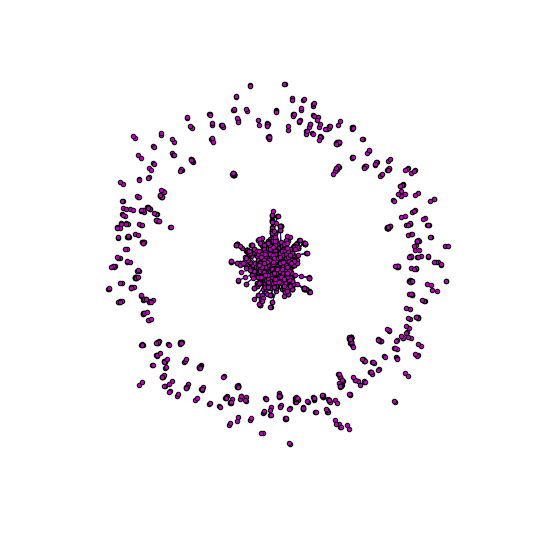

In [59]:
# plot all of the nodes and edges in the graph
fig = plt.figure(figsize = (7, 7))
G = nx.read_edgelist('personality_edges.txt')
pos = nx.spring_layout(G)
# print len(list(nx.connected_components(G)))
wordlist = ['cultured']
for word in wordlist:
    print G.neighbors(word)

nx.draw(G, pos, node_size=20, node_color='m', edge_color='#191970')
plt.show()


# for l in list(nx.connected_components(G)):
#     print l, '\n'

In [84]:
pers_dict2 = dict()
wordlist2 = '''peaceful, calm, tranquil, serene, relax, quiet, harmonious, relaxed, easygoing, serenity, relaxation, \
carefree, comfortable, sedate, pastoral, decompress, laid_back, comfortable, easy, calming, relaxing, comforting, unwind, \
rest, repose, low_key, soothing, restful'''.split(', ')

for trait in wordlist2:
    personality_words = [trait]
    synonyms = wn.synsets(trait.lower())
    synlist = [trait.lower()]
    for s in synonyms:
        synlist = [l.name() for l in s.lemmas()]
        personality_words.extend([wordnet.lemmatize(w) for w in synlist])
    pers_dict2[trait] = personality_words

syns = set([item for sublist in pers_dict2.values() for item in sublist])

edges = []
for syn in syns: 
    keys_lst = []
    keys_lst = [key for key, value in pers_dict2.items() if syn in value]
    if len(keys_lst) > 1:
        edges.extend(list(itertools.combinations(keys_lst, 2)))
        
with open('trait_edges.txt', 'w') as f:
    for edge in edges:
        f.write(edge[0] + ' ' + edge[1] + '\n')

# fig = plt.figure(figsize = (5, 5))
G = nx.read_edgelist('trait_edges.txt')
pos = nx.spring_layout(G)

max_deg = Counter(nx.degree_centrality(G)).most_common(1)[0][0]
max_eig = Counter(nx.eigenvector_centrality(G)).most_common(1)[0][0]
nbrs = G.neighbors(max_deg)
print 'most important word (degree centrality): ', max_deg
print 'most important word (eigenvector centrality): ', max_eig


if len(nbrs) < 10:
    lst2 = []
    for nbr in nbrs:
        lst2.extend([g for g in G.neighbors(nbr) if g not in nbrs and g != max_deg])
    nbrs.extend(lst2)

print 'neighbors = ', nbrs
# nx.draw(G, pos, node_size=20, node_color='m', edge_color='#191970')
# nx.draw_networkx_nodes(G, pos, nodelist=[max_deg, max_eig], node_color='#EE1289', node_size=100)
# plt.show()

db = np.append(doc_bodies, ' '.join(nbrs))
stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stops)

X = vectorizer.fit_transform(db)
# print len(doc_bodies)
# 1. Compute cosine similarity
cosine_similarities = linear_kernel(X, X)

sims = np.zeros([len(db),])
# 2. Print out similarities
for i, doc1 in enumerate(db):
    for j, doc2 in enumerate(db):
        if i == len(db) - 1 and j < len(db) -1:
            sims[j] = cosine_similarities[i, j]
top10 = np.argsort(sims)[::-1][:10]

for i in top10:
    print cities[i], ':',', '.join(set(tokenized_corpus[i]) & set(nbrs))

most important word (degree centrality):  quiet
most important word (eigenvector centrality):  quiet
neighbors =  [u'calming', u'serene', u'rest', u'repose', u'calm', u'sedate', u'relaxation', u'tranquil', u'serenity', u'comforting', u'comforting', u'comforting']
Hamilton, Scotland : tranquil
Liverpool, England : serene
Le Havre, France : calming, rest, relaxation
Slough, England : tranquil, calm, rest, relaxation
Woking, England : calming, tranquil, sedate, rest, calm
Bristol, England : calming, serene, rest, calm, comforting, tranquil
Malmo, Sweden : tranquil, calm, rest, relaxation
Wroclaw, Poland : tranquil, serene, serenity, rest, calm
Monaco : serene, tranquil, rest, calm
Marseille, France : tranquil, serene, serenity, rest, calm


In [ ]:
plt.figure(figsize=(10, 10))
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')
colors = ['r', 'g', 'b', 'm', 'c', 'k', 'y']
geolocator = Nominatim()
sz = 20. * sims / max(sims) + 8
alp = (sims / max(sims))/2 + 0.1
print min(alp)
print max(alp)

print type(sz)
xpts = []
ypts = []
for i, city in enumerate(cities):
    location = geolocator.geocode(city, timeout=10)
    if location is not None:
        xpt, ypt = m(location.longitude, location.latitude)
        xpts.append(xpt)
        ypts.append(ypt)
plt.scatter(xpts, ypts, s=sz[i], color='g', alpha=alp)

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
plt.savefig('city_example.png', bbox_inches='tight')
m.drawmapboundary(fill_color='#1E90FF')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='#F5DEB3',lake_color='#1E90FF')
plt.show()
# s = [20*4**n for n in range(len(x))]


0.1
0.6
<type 'numpy.ndarray'>


In [48]:
synonyms = wn.synsets('relaxing'.lower())

synlist = []
for s in synonyms:
    synlist = [l.name() for l in s.lemmas()]
    personality_words.extend([wordnet.lemmatize(w) for w in synlist])
print set(personality_words)
print synlist

set([u'unwind', u'loosen', u'reposeful', u'rest', 'soothing', u'soothe', u'liberalization', u'loosen_up', u'slack_up', u'console', u'solace', u'ease', u'comfort', u'loosening', u'easiness', u'slackening', u'unstrain', u'relaxation_behavior', u'unbend', u'relax', u'liberalisation', u'loose', u'decompress', u'repose', u'relaxation', u'slow_down', u'assuasive', u'relaxation_method', u'relaxing', u'slack', u'slacken', u'unlax', u'make_relaxed', u'restful'])
[u'restful', u'reposeful', u'relaxing']


## Plot word frequency of remaining words

Word in corpus: 2102
Maximum word frequency: 17441


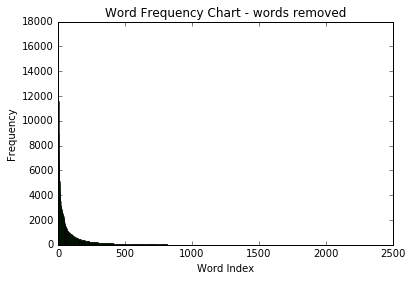

In [25]:
# tokenized_corpus = tokenized_corpus_4
# doc_bodies = docs_wordnet
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus_4, 'words removed')
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [26]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove any words that are very common
commonwords = word_ids[values > 4000]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

['even', 'best', 'lovely', 'amazing', 'first', 'one', 'little', 'small', 'good', 'wonderful', 'like', 'nice', 'go', 'great', 'well']


## Remove stopwords and plot new frequency

In [26]:
tokenized_corpus_1 = remove_stopwords(tokenized_corpus)
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus_1, 'all words included')
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

Word in corpus: 14677
Maximum word frequency: 17441


KeyboardInterrupt: 

In [ ]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove any words that are very common
commonwords = word_ids[values > 2000]
common_removelist = [vocab_dict[c] for c in commonwords]

uncommonwords = word_ids[values == 1]
uncommon_removelist = [vocab_dict[c] for c in uncommonwords]

# remove two letter words|
two_letter = [word for word in vocab if len(word) < 3]

# Limit by part of speech
remove_non = limit_speech_part(tokenized_corpus, ['ADJ', 'ADV'])

In [ ]:
personalities = get_personality_words()
non_personalities = []
for words in tokenized_corpus:
    for word in words:
        syns = []
        synonyms = wn.synsets(word.lower())
        for s in synonyms:
            synlist = [l.name() for l in s.lemmas()]
            syns.extend(synlist)
        if len(set.intersection(set(syns), personalities)) == 0:
            non_personalities.append(word)


In [ ]:
remove_more = ['turkish', 'german', 'english', 'russian', 'ukrainian', 'lithuanian', 'spanish', 'serbian',
               'armenian', 'italian', 'greek', 'croatian', 'finnish', 'polish', 'estonian', 'french', 'swiss',
               'czech', 'latvian', 'irish', 'danish', 'macedonian', 'welsh', 'bulgarian', 'british', 'norwegian',
               'scottish', 'belgian', 'american', 'hungarian', 'cyrillic', 'european','dutch','gaelic','yugoslav',
               'scandinavian','bosnia','herzegovina', 'europe', 'america', 'andorra', 'petersburg', 'catherine',
               'romanov', 'peter', 'favoritethis', 'liechtenstein', 'austrian', 'flemish', 'georgian', 'tuscan', 
               'nazi', 'byzantine', 'roman', 'venetian', 'large', 'main', 'found', 'enough', 'located', 'done',
               'second', 'full', 'booked', 'right', 'square', 'rum', 'ordered', 'easy', 'spent', 'sure', 'august',
              'near', 'fly', 'still' ,'flip', 'becoming', 'minute', 'laid', 'arch', 'set', 'long', 'black', 'animal',
              'longer', 'used','able', 'whole', 'last', 'big', 'high', 'star', 'come', 'close', 'bit', 'line' ,'new',
              'train', 'think', 'left', 'end', 'say', 'child', 'pas', 'drive', 'white', 'offer', 'guided', 'experience',
              'space', 'know', 'cannot', 'situated', 'closed', 'thorough', 'fantastic', 'excellent', 'better','special',
               'perfect','taking','short','house', 'base', 'golden', 'blue', 'gold', 'driving','inner','kart','dress','pronounced',
              'loved','ms','perpendicular','open','game','past','experienced','contained','home', 'weather', 'age', 
               'wanted', 'start','dog', 'ground','el','variety', 'range', 'hard', 'check', 'spot', 'sculpture','floor','point',
              'spot', 'give', 'thought','quarter','seat', 'lower','behind','however','late','nearly','fairly','live',
              'interested']


# remove any words that are very common
common = word_ids[values > 2000]
common_list = [vocab_dict[c] for c in common]
tokenized_corpus = remove_stopwords(tokenized_corpus, common_removelist + two_letter + uncommon_removelist + 
                                    remove_more + non_personalities + common_list)

# tokenized_corpus = remove_stopwords(tokenized_corpus)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'custom stop words removed')

vocab_dict = {i: word for i, word in enumerate(vocab)}


print common_list
print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [ ]:
stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stops + remove_more + remove_non + common_removelist + common_list + non_personalities)
# vectorizer = CountVectorizer(stop_words=stops + remove_more + uncommon_removelist + common_list +
#                              common_removelist + non_personalities)
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()

In [ ]:
x_dense = X.todense()
# print x_dense
# print x_dense.max()
for i, doc in enumerate(x_dense):
    d = np.array(doc)[0]
    print cities[i]
    top_indices = np.array(np.argsort(d)[::-1][:8])
    print np.array(features)[top_indices]

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-13:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

# 3. Print out the titles of a random sample of the articles assigned to each
# cluster to get a sense of the topic.
# assigned_cluster = kmeans.transform(X).argmin(axis=1)
# for i in range(kmeans.n_clusters):
#     cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
#     sample_cities = np.random.choice(cluster, 2, replace=False)
#     print "cluster %d:" % i
#     for city in sample_cities:
#         print "    %s" % cities[city].strip('\n')

In [ ]:
print x_dense.shape

# indices = np.argsort(vectorizer.idf_)[::-1]
# features = vectorizer.get_feature_names()
# top_n = 2
# top_features = [features[i] for i in indices[:top_n]]
# print top_features
# print vectorizer.idf_.shape

# features_dict = defaultdict(list)
# for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
#     features_dict[len(f.split(' '))].append((f, w))
# top_n = 2
# for gram, features in features_dict.iteritems():
#     top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
#     top_features = [f[0] for f in top_features]
#     print '{}-gram top:'.format(gram), top_features
from itertools import izip

def sort_coo(m):
    tuples = izip(m.row, m.col, m.data)
    return sorted(tuples, key=lambda x: (x[0], x[2]))

for entry in X.shape[0:
    d = X.getrow(i)


## Implement K-means Clustering to group cities by common features

In [ ]:
# remove_words = []
# # options are ADJ, ADV, VERB, NOUN
# for content in doc_bodies:
#     for word in content.split():
#         speech_check = wn.synsets(word, pos=wn.ADJ)
#         if len(speech_check) == 0:
#             remove_words.append(word)
# #         else:
# #             print word

## K-means Clustering Limiting by Part of Speech

In [ ]:
wordnet = WordNetLemmatizer()
# read list of personality words
with open('personalitywords.txt') as f:
    personality_words = []
    for line in f:
        for word in line.split():
            synonyms = wn.synsets(word.lower())
            for s in synonyms:
                synlist = [l.name() for l in s.lemmas()]
            synlist.append(word.lower())
            personality_words.extend([wordnet.lemmatize(w) for w in synlist])
            
# make dictionaries out of rick steves data
rs_dict = json_to_dict('ricksteves3.json')



# Convert dictionary into dataframe
cities_df = pd.DataFrame.from_dict(rs_dict, orient='index', dtype=None)
cities_df.columns = ['description']

# Extract cities and their descripitions from dataframe
doc_bodies = cities_df['description'].values
cities = cities_df.index.values

# Create a tokenized version of the corpus for frequency plots
tokenized_corpus = [word_tokenize(content.lower()) for content in doc_bodies]
# lemmatize

porter = PorterStemmer()
snowball = SnowballStemmer('english')

docs_wordnet = [' '.join([wordnet.lemmatize(word) for word in words.split()]) for words in doc_bodies]
# docs_snowball = [' '.join([snowball.stem(word) for word in words.split()]) for words in doc_bodies]
# docs_porter = [' '.join([porter.stem(word) for word in words.split()]) for words in doc_bodies]

tokenized_corpus_wn = [word_tokenize(content.lower()) for content in docs_wordnet]
# tokenized_corpus_p = [word_tokenize(content.lower()) for content in docs_porter]
# tokenized_corpus_s = [word_tokenize(content.lower()) for content in docs_snowball]

# for wl, w in zip(tokenized_corpus[1], tokenized_corpus_wn[1]):
#     if wl != w:
#         print wl, w
        
tokenized_corpus = tokenized_corpus_wn
doc_bodies = docs_wordnet

# tokenized_corpus = tokenized_corpus_s
# doc_bodies = docs_snowball

# tokenized_corpus = tokenized_corpus_p
# doc_bodies = docs_porter

In [ ]:
# remove nltk stopwords
tokenized_corpus = remove_stopwords(tokenized_corpus)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'nltk stopwords removed')

print 'Word in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [ ]:
vocab_dict = {i: word for i, word in enumerate(vocab)}

# remove any words that appears more than 200 times
commonwords = word_ids[values > 200]
common_removelist = [vocab_dict[c] for c in commonwords]
print common_removelist

# remove words that are not personality words
non_pers_words = [word for word in vocab if word not in set(personality_words)]
tokenized_corpus = remove_stopwords(tokenized_corpus, common_removelist)

# plot the word frequencies
values, vocab, word_ids = plot_word_frequencies(tokenized_corpus, 'common words removed')

print 'Words in corpus: {}'.format(len(values))
print 'Maximum word frequency: {}'.format(int(max(values)))

In [ ]:
remove_more = ['cathedral', 'center', 'house', 'home', 'der', 'turkish', 'german', 'english', 'russian', 'ukrainian',
              'lithuanian', 'spanish', 'serbian', 'armenian', 'italian', 'greek', 'croatian', 'finnish', 'polish',
              'estonian', 'like', 'french', 'swiss', 'czech', 'next', 'northwest', 'southwest', 'latvian', 'irish',
              'side', 'danish', 'macedonian', 'welsh', 'bulgarian', 'british', 'august', 'pass', 'overnight', 'rick',
              'norwegian', 'scottish', 'belgian', 'american', 'mid', 'second', 'hungarian', 'domestic', 'zero','terminal',
              'within', 'one','cyrillic','select','key','first','much','back','still','made','every','north','several',
              'world','long','extra','firsthand','european','five','dutch','top','done','gaelic','yugoslav','three','south',
              'scandinavian','bosnia','herzegovina','dime','nickel','cannot','right','left','minute','taking','low',
              'behind']

stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stops+remove_words+remove_more)
X = vectorizer.fit_transform(doc_bodies)
features = vectorizer.get_feature_names()
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# 2. Find the top features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:, -1:-13:-1]
print "top features for each cluster:"
for num, centroid in enumerate(top_centroids):
    print "%d: %s" % (num, ", ".join(features[i] for i in centroid))

# 3. Print out the titles of a random sample of the articles assigned to each
# cluster to get a sense of the topic.
assigned_cluster = kmeans.transform(X).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
    sample_cities = np.random.choice(cluster, 2, replace=False)
    print "cluster %d:" % i
    for city in sample_cities:
        print "    %s" % cities[city].strip('\n')

In [ ]:
matplotlib.use('Agg')

plt.figure(figsize=(10, 10))
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')
colors = ['r', 'g', 'b', 'm', 'c', 'k', 'y']
geolocator = Nominatim()
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster == i]
    for city in cluster:
        location = geolocator.geocode(cities[city], timeout=10)
        if location is not None:
            xpt, ypt = m(location.longitude, location.latitude)
            plt.plot(xpt, ypt, '.', color=colors[i], alpha=0.5, markersize=20)

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
plt.savefig('city_clusters.png', bbox_inches='tight')
plt.show()

In [ ]:
ambiance = ['relaxing','calm','unwind','laze','soothing','harmonious','mild','serene','slow','tranquil',
           'quiet','peaceful','soft','lounging']
syns = build_synonym_list(ambiance)

In [ ]:
# Cosine Similarity using TF-IDF
# type(doc_bodies)
# type(cities)

doc_bodies.append(' '.join(syns))
stops = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words= stops)

db = doc_bodies
X = vectorizer.fit_transform(db)
# print len(doc_bodies)
# 1. Compute cosine similarity
cosine_similarities = linear_kernel(X, X)

sims = np.zeros([len(db),])
# 2. Print out similarities
for i, doc1 in enumerate(db):
    for j, doc2 in enumerate(db):
        if i == len(db) - 1:
            sims[j] = cosine_similarities[i, j]
#             print i, j, cosine_similarities[i, j]

In [ ]:
print cities[np.argmax(sims[:-1])]
max(sims[:-1])

In [ ]:
# print doc_bodies['Hamburg, Germany']

for word in doc_bodies[np.argmax(sims)].split():
    if word in set(syns):
        print word

In [ ]:
doc_bodies[np.argmax(sims)]

In [ ]:
us_dict = json_to_dict('us_cities.json')

In [ ]:
print cities

In [ ]:
with open('us_cities.txt', 'w') as f:
    for key in us_dict:
        f.write(key + '\n')

In [ ]:
plt.figure(figsize=(10, 10))
m = Basemap(projection='stere', lon_0=5, lat_0=90.0, rsphere=6371200., llcrnrlon=-25.0,
            urcrnrlon=90.0, llcrnrlat=26.0, urcrnrlat=50.0, resolution='l')
colors = ['r', 'g', 'b', 'm', 'c', 'k', 'y']
geolocator = Nominatim()
for city in cities:
    location = geolocator.geocode(city, timeout=10)
    if location is not None:
        xpt, ypt = m(location.longitude, location.latitude)
        plt.plot(xpt, ypt, '.', color='g', markersize=10)
        
citlist = ['Venice, Italy', 'Paris, France', 'Rome, Italy', 'London, England', 'Moscow, Russia', 'Athens, Greece',
          'Bern, Switzerland']
for c in citlist:
    location = geolocator.geocode(c, timeout=10)
    xpt, ypt = m(location.longitude, location.latitude)
    plt.plot(xpt, ypt, '.', color='m', markersize=10)

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)
plt.savefig('city_example.png', bbox_inches='tight')
m.drawmapboundary(fill_color='#1E90FF')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='#F5DEB3',lake_color='#1E90FF')
plt.show()